## Python3 code to read Persist Task eprime output files (txt output)
Jamil Bhanji<br>
bhanji@psychology.rutgers.edu<br>
April 18, 2018<br>

In [1]:
import os
import sys
import json
import codecs
import pandas as pd
import io
import chardet
import codecs


In [9]:
topdir = "/mnt/delgadolab/jamil/opiod_mita" #study directory (full path)
bidstsvformat = topdir + '/BIDS/sub-%s/func/sub-%s_task-%s_run-%s_events.tsv' #format for saving tsv file
# func_tasks = { 
#     "cardtask": "CardTaskRPN_order1-101-1",
#     "persist": "PathTaskfmri_order1-101-1"
# } #would be nice to just iterate through all files but they are too idosyncratic at the moment
subjectlist = ['601','603','604','605','606','607','608','609','610','615','616','617','618','620','622','624',
               '802','803','804','806','807','808','809','810','811','812','813','814','815','816','817']
group_list = ["PO+stress","PO-stress","Control"]
patient_group_list = ["Opiod", "Control"]
subject_groups = { 
    "PO+stress": ['601','604','606','608','609','610','615'], #after each groupname include participant labels list
    "PO-stress": ['603','605','607','616','617','618','620','622','624'],
    "Control": ['802','803','804','806','807','808','809','810','811','812','813','814','815','816','817']
} 

### Generate \_events.tsv for the persist task (pathtask)
* event onsets for choice, obstacle response (cue), obstacle feedback, goal feedback 
* persist choice, choice rt, obstacle rt stored in an additional columns
* event types (this version does not include the lodiff condition, but it is listed for consistency):
    * __firstchoice__ - first path choice of round
    * __postunclodiffchoice__ - path choice after uncontrollable, lodiff 
        uncontrollable means setback framed as random
        lodiff means path values were similar
    * __postconlodiffchoice__ - path choice after controllable, lodiff 
        controllable means setback framed as random
    * __postunchidiffchoice__ - path choice after uncontrollable, hidiff (dissimilar path values) 
    * __postconhidiffchoice__ - path choice after controllable, hidiff 
    * __poscuefbk__ - progress cue and feedback
    * __cueunclodiff__ - uncontrollable obstacle, lodiff condition
    * __cueconlodiff__ - controllable obstacle, lodiff condition
    * __cueunchidiff__ - uncontrollable obstacle, hidiff condition
    * __cueconhidiff__ - controllable obstacle, hidiff condition
    * __sbkunclodiff__ - uncontrollable lodiff setback (negative feedback)
    * __sbkconlodiff__ - controllable lodiff setback (negative feedback)
    * __sbkunchidiff__ - uncontrollable hidiff setback (negative feedback)
    * __sbkconhidiff__ - controllable hidiff setback (negative feedback)
    * __posunclodiff__ - uncontrollable lodiff avoided setback
    * __posconlodiff__ - controllable lodiff avoided setback 
    * __posunchidiff__ - uncontrollable hidiff avoided setback 
    * __posconhidiff__ - controllable hidiff avoided setback
    * __goalpos__ - end of path reached
    * __goalneg__ - goal not reached
    * __misschoice__ - missed path choice
    * __missposcue__ - missed progress cue response
    * __misscue__ - missed obstacle response
    * __missfbk__ - feedback after missed obstacle response
    
* in the future, write code to autogenerate participants.tsv with columns for emotion ratings from the e-prime file

In [10]:
def persist_eprime_txt_to_tsv(infile, encodingtype, outfile, group):
    """
    Read e-prime style txt from PathTask_fmri E-Prime (1 scan)
    Output a tab separated file (1 for each scan), BIDS compliant
    """    
    #nruns = len(outfiles)
    events_per_run = 88 #this counts cue and feedback as 1 event, but they will get entered as separate events in the tsv (modeled separately)
    
    with codecs.open(infile, encoding=encodingtype) as f:
        text_data = list(f)
        trimmed_data = [str.strip(line) for line in text_data]
        # Determine start and end rows of each trial.
        #trialstarts = [i for i, line in enumerate(trimmed_data) if 'EventList1: ' in line] 
        trialstarts = [i for i, line in enumerate(trimmed_data) if '*** LogFrame Start ***' in line][:-1] #last one is summary info (drop it)
        trialends = [i for i, row in enumerate(trimmed_data) if row == '*** LogFrame End ***'][:-1] #last one is summary info (drop it)
        #print(trialstarts, len(trialstarts))
        outdf = pd.DataFrame(columns=['onset','duration','trial_type','persist_choice','switch_choice','response_time'])
        #runnum = runidx+1
        #runfirstevent = runidx*events_per_run
        #current_trialstarts = trialstarts[runfirstevent:((runidx+1)*events_per_run)]
        #print ("run %02d startlines:" % runnum)
        #print (current_trialstarts, len(current_trialstarts))
        for counter, startidx in enumerate(trialstarts):  #trial loop start
            endidx = trialends[counter]
            onetrial = trimmed_data[startidx:endidx]
            #print(counter,startidx, endidx)
            for line in onetrial:
                if "EventType:" in line:
                    event = int(line.split(":")[1]) #1=unccue,2=concue,3=poscue,4=pathchoice,6=goalfbk
                if "ChoosePath.OnsetTime:" in line:
                    eprime_choice_onset = int(line.split(":")[1])/1000
                    if counter == 0:
                        trigger = eprime_choice_onset - 4 #4s fixation between scan trigger and first trial
                    choice_onset = eprime_choice_onset - trigger
                if "GoalFbk.OnsetTime:" in line:
                    goal_onset = int(line.split(":")[1])/1000 - trigger
                if "ue.OnsetTime:" in line: #matches greencue onset and cue onset
                    cue_onset = int(line.split(":")[1])/1000 - trigger
                if ("Fbk.OnsetTime:" in line) and (not ("GoalFbk" in line)) : #matches greenfbk onset and fbk onset
                    fbk_onset = int(line.split(":")[1])/1000 - trigger
                if "Lose:" in line:
                    lose = int(line.split(":")[1]) #0=nosetback, 1=setback
                if "ValueDiff:" in line:
                    valuediff = int(line.split(":")[1]) #1=lodiff, 2=hidiff
                if "NewRound:" in line:
                    newround = int(line.split(":")[1]) #1=first choice of round
                if "condition:" in line:
                    conditionstr = str.strip(line.split(":")[1])
                if "PostCuejit:" in line:
                    postcuejit = int(line.split(":")[1])/1000
                if "PostFbkjit:" in line:
                    postfbkjit = int(line.split(":")[1])/1000
                if "ChoosePath.RT:" in line:
                    choice_rt = int(line.split(":")[1])/1000
                if "postChoiceFixation.RT:" in line:
                    latechoice_rt = int(line.split(":")[1])/1000
                if "Cue.RT:" in line:
                    cue_rt = int(line.split(":")[1])/1000
                if "Persist:" in line:
                    persist_choice = int(line.split(":")[1])
                if "Switch:" in line:
                    switch_choice = int(line.split(":")[1])
                if "yescap" in line:
                    goal_event = "goalpos"
                if "nocap" in line:
                    goal_event = "goalneg"
            valuestr = "hidiff" if valuediff == 2 else "lodiff"
            condabbrev = "unc" if conditionstr == "uncontrollable" else "con"
            fbkval = "pos" if lose == 0 else "sbk"
            if event==4:
                #pathchoice event
                event_onset = choice_onset
                if (choice_rt == 0 and latechoice_rt == 0):
                    trial_type = "misschoice"
                    response_time = float('nan')
                else:
                    response_time = 2 + latechoice_rt if choice_rt == 0 else choice_rt
                    if newround == 1:
                        trial_type = "firstchoice"
                    else:
                        trial_type = "post%s%schoice" % (condabbrev,valuestr)
                trial_duration = 2
                outdf = outdf.append({'onset': event_onset,'duration': trial_duration, 'trial_type': trial_type, 
                                      'persist_choice':persist_choice, 'switch_choice':switch_choice, 
                                      'response_time': response_time, 'group': group}, ignore_index=True)
            elif event==6: #goal fbk event
                event_onset = goal_onset
                trial_type = goal_event
                trial_duration = 2
                response_time = float('nan')
                outdf = outdf.append({'onset': event_onset,'duration': trial_duration, 'trial_type': trial_type, 'response_time': response_time, 'group': group}, ignore_index=True)
            elif event==3: #progress cue event
                event_onset = cue_onset
                trial_type = "poscuefbk"
                trial_duration = 4
                response_time = cue_rt if cue_rt > 0 else float('nan')
                outdf = outdf.append({'onset': event_onset,'duration': trial_duration, 'trial_type': trial_type, 'response_time': response_time, 'group': group}, ignore_index=True)
            elif (event==1 or event==2): #unc obstacle
                cue_type = "cue%s%s" % (condabbrev,valuestr)
                fbk_type = "%s%s%s" % (fbkval,condabbrev,valuestr)
                outdf = outdf.append({'onset': cue_onset,'duration': 2, 'trial_type': cue_type, 'response_time': cue_rt, 'group': group}, ignore_index=True)
                outdf = outdf.append({'onset': fbk_onset,'duration': 2, 'trial_type': fbk_type, 'response_time': float('nan'), 'group': group}, ignore_index=True)
            event=0 #reset event (fixes last line problem)
        #trialloop end
    choice_idxs = outdf.loc[(outdf.trial_type=='postconhidiffchoice') | 
                         (outdf.trial_type=='postconlodiffchoice') |
                         (outdf.trial_type=='postunchidiffchoice') |
                         (outdf.trial_type=='postunclodiffchoice')].index
    sbk_idxs = choice_idxs - 1
    for counter, row_idx in enumerate(sbk_idxs): #fill setback rows with subsequent choice info
        outdf.loc[row_idx,'persist_choice'] = outdf.loc[choice_idxs[counter],'persist_choice']
        outdf.loc[row_idx,'switch_choice'] = outdf.loc[choice_idxs[counter],'switch_choice']
    outdf = outdf.round(3)
    if not ("misschoice" in outdf['trial_type'].values):  #add empty row if no missed trials
        outdf = outdf.append({'onset': 0,'duration': 0, 'trial_type': "misschoice", 'response_time': float('nan')}, ignore_index=True)
    outdf.to_csv(outfile, sep='\t', float_format='%.3f', index=False)

In [11]:
def BIDStoFSL3col(bidseventfile,basename):
    cmd = '/mnt/delgadolab/generaltools/bidsutils/BIDSto3col/BIDSto3col.sh %s %s' % (bidseventfile,basename)
    #print (cmd)
    !{cmd}

In [12]:
# read e-prime txt files and output event.tsv
# subjectlist = ['601','603','604','605','606','607','608','609','610','615','616','617','618','620',
#                '802','803','804','806','807','808','809','810','811','812']
eprimepathformat = topdir + "/sourcedata/behavior/PersistTask" #to construct pathname

for igroup, group in enumerate(group_list):
    for isub, sub in enumerate(subject_groups[group]):
        print ("subject %s persist task" % (sub))
        eprime_dir = eprimepathformat
        taskname = "persist"
        runnum = "01"
        infile = eprime_dir + "/PathTaskfmri_order1-%s-1.txt" % (sub)
        #check encoding type (utf-16 or utf-8)
        bytes = min(32, os.path.getsize(infile))
        raw = open(infile, 'rb').read(bytes)
        result = chardet.detect(raw)
        encodingtype = result['encoding'] #pass this encoding type var to the routine that reads the files 
        bidsoutfile = bidstsvformat % (sub, sub, taskname, runnum)
        #multiple runs??
    #     outfiles = []
    #     for runidx in range(nruns):
    #         runstr = '%02d' % (runidx + 1)
    #         outfiles.append( bidstsvformat % (sub, sub, taskname, runstr))

        FSL3colfolder = topdir + "/analysis/persist/sub-%s/basicpersistmodel/onsets" % (sub)
        FSL3colbasename = FSL3colfolder + "/basicpersistmodel"
        os.makedirs(FSL3colfolder, exist_ok=True)
        print (infile)
        print(FSL3colbasename)
        persist_eprime_txt_to_tsv(infile,encodingtype,bidsoutfile,group)
        BIDStoFSL3col(bidsoutfile, FSL3colbasename)
    


subject 601 persist task
/mnt/delgadolab/jamil/opiod_mita/sourcedata/behavior/PersistTask/PathTaskfmri_order1-601-1.txt
/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-601/basicpersistmodel/onsets/basicpersistmodel
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-601/basicpersistmodel/onsets/basicpersistmodel_cueconhidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-601/basicpersistmodel/onsets/basicpersistmodel_cueunchidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-601/basicpersistmodel/onsets/basicpersistmodel_firstchoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-601/basicpersistmodel/onsets/basicpersistmodel_goalneg.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-601/basicpersistmodel/onsets/basicpersistmodel_goalpos.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-601/basicpersistmodel/onsets/basicpersistmodel_misschoice.txt'
Creating '/mnt/del

Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-609/basicpersistmodel/onsets/basicpersistmodel_misschoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-609/basicpersistmodel/onsets/basicpersistmodel_posconhidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-609/basicpersistmodel/onsets/basicpersistmodel_poscuefbk.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-609/basicpersistmodel/onsets/basicpersistmodel_postconhidiffchoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-609/basicpersistmodel/onsets/basicpersistmodel_postunchidiffchoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-609/basicpersistmodel/onsets/basicpersistmodel_posunchidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-609/basicpersistmodel/onsets/basicpersistmodel_sbkconhidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-609/basicpersistmodel/on

subject 607 persist task
/mnt/delgadolab/jamil/opiod_mita/sourcedata/behavior/PersistTask/PathTaskfmri_order1-607-1.txt
/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-607/basicpersistmodel/onsets/basicpersistmodel
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-607/basicpersistmodel/onsets/basicpersistmodel_cueconhidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-607/basicpersistmodel/onsets/basicpersistmodel_cueunchidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-607/basicpersistmodel/onsets/basicpersistmodel_firstchoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-607/basicpersistmodel/onsets/basicpersistmodel_goalneg.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-607/basicpersistmodel/onsets/basicpersistmodel_goalpos.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-607/basicpersistmodel/onsets/basicpersistmodel_misschoice.txt'
Creating '/mnt/del

Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-620/basicpersistmodel/onsets/basicpersistmodel_poscuefbk.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-620/basicpersistmodel/onsets/basicpersistmodel_postconhidiffchoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-620/basicpersistmodel/onsets/basicpersistmodel_postunchidiffchoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-620/basicpersistmodel/onsets/basicpersistmodel_posunchidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-620/basicpersistmodel/onsets/basicpersistmodel_sbkconhidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-620/basicpersistmodel/onsets/basicpersistmodel_sbkunchidiff.txt'
subject 622 persist task
/mnt/delgadolab/jamil/opiod_mita/sourcedata/behavior/PersistTask/PathTaskfmri_order1-622-1.txt
/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-622/basicpersistmodel/onsets/basicpersist

subject 804 persist task
/mnt/delgadolab/jamil/opiod_mita/sourcedata/behavior/PersistTask/PathTaskfmri_order1-804-1.txt
/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-804/basicpersistmodel/onsets/basicpersistmodel
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-804/basicpersistmodel/onsets/basicpersistmodel_cueconhidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-804/basicpersistmodel/onsets/basicpersistmodel_cueunchidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-804/basicpersistmodel/onsets/basicpersistmodel_firstchoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-804/basicpersistmodel/onsets/basicpersistmodel_goalneg.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-804/basicpersistmodel/onsets/basicpersistmodel_goalpos.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-804/basicpersistmodel/onsets/basicpersistmodel_misschoice.txt'
Creating '/mnt/del

Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-809/basicpersistmodel/onsets/basicpersistmodel_poscuefbk.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-809/basicpersistmodel/onsets/basicpersistmodel_postconhidiffchoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-809/basicpersistmodel/onsets/basicpersistmodel_postunchidiffchoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-809/basicpersistmodel/onsets/basicpersistmodel_posunchidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-809/basicpersistmodel/onsets/basicpersistmodel_sbkconhidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-809/basicpersistmodel/onsets/basicpersistmodel_sbkunchidiff.txt'
subject 810 persist task
/mnt/delgadolab/jamil/opiod_mita/sourcedata/behavior/PersistTask/PathTaskfmri_order1-810-1.txt
/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-810/basicpersistmodel/onsets/basicpersist

subject 814 persist task
/mnt/delgadolab/jamil/opiod_mita/sourcedata/behavior/PersistTask/PathTaskfmri_order1-814-1.txt
/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-814/basicpersistmodel/onsets/basicpersistmodel
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-814/basicpersistmodel/onsets/basicpersistmodel_cueconhidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-814/basicpersistmodel/onsets/basicpersistmodel_cueunchidiff.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-814/basicpersistmodel/onsets/basicpersistmodel_firstchoice.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-814/basicpersistmodel/onsets/basicpersistmodel_goalneg.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-814/basicpersistmodel/onsets/basicpersistmodel_goalpos.txt'
Creating '/mnt/delgadolab/jamil/opiod_mita/analysis/persist/sub-814/basicpersistmodel/onsets/basicpersistmodel_misschoice.txt'
Creating '/mnt/del

In [6]:
# Read behavioral data into pandas dataframe
# subjectlist = ['601','603','604','605','606','607','608','609','610','615','616','617','618','620',
#                '802','803','804','806','807','808','809','810','811','812']
eprimepathformat = topdir + "/PersistTask" #to construct pathname
taskname = "persist"
runnum = "01"

stacked_behav_df = pd.DataFrame(columns=['subject','group','onset','duration','trial_type','persist_choice','switch_choice','response_time'])
restruct_behav_df = pd.DataFrame(columns=['subject','group','unc_persist_percent','unc_switch_percent','unc_response_time',
                                          'con_persist_percent','con_switch_percent','con_response_time'])
semistacked_behav_df = pd.DataFrame(columns=['subject','group','condition','persist_percent','switch_percent','response_time'])
for sub in subjectlist:
    eventsfile = bidstsvformat % (sub, sub, taskname, runnum)
    sub_df = pd.read_csv(eventsfile,sep='\t')
    sub_df['subject']=sub
    group = sub_df['group'][0]
    unc_persist_percent = sub_df.loc[sub_df.trial_type=='postunchidiffchoice',:].persist_choice.sum() / \
                          sub_df.loc[sub_df.trial_type=='postunchidiffchoice',:].persist_choice.count()
    unc_switch_percent = sub_df.loc[sub_df.trial_type=='postunchidiffchoice',:].switch_choice.sum() / \
                          sub_df.loc[sub_df.trial_type=='postunchidiffchoice',:].switch_choice.count() 
    unc_response_time = sub_df.loc[sub_df.trial_type=='postunchidiffchoice',:].response_time.mean()
    con_persist_percent = sub_df.loc[sub_df.trial_type=='postconhidiffchoice',:].persist_choice.sum() / \
                          sub_df.loc[sub_df.trial_type=='postconhidiffchoice',:].persist_choice.count()
    con_switch_percent = sub_df.loc[sub_df.trial_type=='postconhidiffchoice',:].switch_choice.sum() / \
                          sub_df.loc[sub_df.trial_type=='postconhidiffchoice',:].switch_choice.count() 
    con_response_time = sub_df.loc[sub_df.trial_type=='postconhidiffchoice',:].response_time.mean()
    restruct_behav_df = restruct_behav_df.append({'subject': sub, 'group': group,
                                              'unc_persist_percent': unc_persist_percent, 
                                              'unc_switch_percent': unc_switch_percent, 
                                              'unc_response_time': unc_response_time, 
                                              'con_persist_percent': con_persist_percent,
                                              'con_switch_percent': con_switch_percent,
                                              'con_response_time': con_response_time
                                             }, ignore_index=True)
    semistacked_behav_df = semistacked_behav_df.append({'subject': sub, 'group': group, 'condition': "uncontrollable",
                                                        'persist_percent': unc_persist_percent, 
                                                        'switch_percent': unc_switch_percent, 
                                                        'response_time': unc_response_time
                                                       }, ignore_index=True)
    semistacked_behav_df = semistacked_behav_df.append({'subject': sub, 'group': group, 'condition': "controllable",
                                                        'persist_percent': con_persist_percent,
                                                        'switch_percent': con_switch_percent,
                                                        'response_time': con_response_time
                                                       }, ignore_index=True)
    stacked_behav_df = stacked_behav_df.append(sub_df)



In [7]:
restruct_behav_df['patientgroup']=restruct_behav_df['group'].replace(to_replace=["PO+stress","PO-stress"], 
                                                                     value="Opiod").astype('category')
stacked_behav_df['patientgroup']=stacked_behav_df['group'].replace(to_replace=["PO+stress","PO-stress"], 
                                                                     value="Opiod").astype('category')
semistacked_behav_df['patientgroup']=semistacked_behav_df['group'].replace(to_replace=["PO+stress","PO-stress"], 
                                                                     value="Opiod").astype('category')
restruct_behav_df['unc_plus_con_persist']= (restruct_behav_df['unc_persist_percent'] + restruct_behav_df['con_persist_percent'])/2

In [8]:
restruct_behav_df.head()

,subject,group,unc_persist_percent,unc_switch_percent,unc_response_time,con_persist_percent,con_switch_percent,con_response_time,patientgroup,unc_plus_con_persist
0,601,PO+stress,0.3,0.4,0.7357,0.571429,0.285714,0.679857,Opiod,0.435714
1,603,PO-stress,0.2,0.3,0.7678,0.200000,0.400000,0.749300,Opiod,0.200000
2,604,PO+stress,0.6,0.1,0.5898,0.800000,0.200000,0.804000,Opiod,0.700000
3,605,PO-stress,0.6,0.2,0.7175,0.333333,0.222222,0.588556,Opiod,0.466667
4,606,PO+stress,0.5,0.3,1.0377,0.444444,0.222222,1.350333,Opiod,0.472222


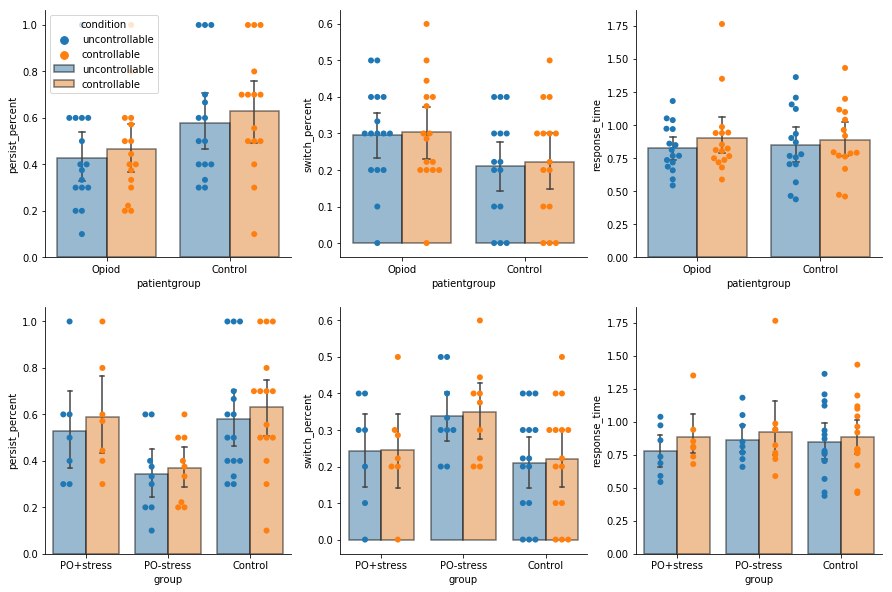

In [10]:
# behavior plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, axarr = plt.subplots(nrows=2, ncols=3, sharey=False, sharex=False)
fig.set_figheight(10)
fig.set_figwidth(15)
#ax.set_title(roi)

ax=axarr[0,0]
sns.barplot(x="patientgroup", y="persist_percent", hue="condition", data=semistacked_behav_df, ax=ax, 
            errwidth=1.5,capsize=.05, alpha=.5, order=patient_group_list, **{"edgecolor":"black", "linewidth":1.5})
sns.swarmplot(x="patientgroup", y="persist_percent", hue="condition", data=semistacked_behav_df, ax=ax, size = 6,
            order=patient_group_list, dodge=True)

ax=axarr[0,1]
sns.barplot(x="patientgroup", y="switch_percent", hue="condition", data=semistacked_behav_df, ax=ax, 
            errwidth=1.5,capsize=.05, alpha=.5, order=patient_group_list, **{"edgecolor":"black", "linewidth":1.5})
sns.swarmplot(x="patientgroup", y="switch_percent", hue="condition", data=semistacked_behav_df, ax=ax, size = 6,
            order=patient_group_list, dodge=True)
ax.get_legend().remove()
ax=axarr[0,2]
sns.barplot(x="patientgroup", y="response_time", hue="condition", data=semistacked_behav_df, ax=ax,
            errwidth=1.5,capsize=.05, alpha=.5, order=patient_group_list, **{"edgecolor":"black", "linewidth":1.5})
sns.swarmplot(x="patientgroup", y="response_time", hue="condition", data=semistacked_behav_df, ax=ax, size = 6,
            order=patient_group_list, dodge=True)
ax.get_legend().remove()

ax=axarr[1,0]
sns.barplot(x="group", y="persist_percent", hue="condition", data=semistacked_behav_df, ax=ax, order=group_list,
            errwidth=1.5,capsize=.05, alpha=.5, **{"edgecolor":"black", "linewidth":1.5})
sns.swarmplot(x="group", y="persist_percent", hue="condition", data=semistacked_behav_df, ax=ax, size = 6,
            order=group_list, dodge=True)
ax.get_legend().remove()

ax=axarr[1,1]
sns.barplot(x="group", y="switch_percent", hue="condition", data=semistacked_behav_df, ax=ax,order=group_list,
            errwidth=1.5,capsize=.05, alpha=.5, **{"edgecolor":"black", "linewidth":1.5})
sns.swarmplot(x="group", y="switch_percent", hue="condition", data=semistacked_behav_df, ax=ax, size = 6,
            order=group_list, dodge=True)
ax.get_legend().remove()
ax=axarr[1,2]
sns.barplot(x="group", y="response_time", hue="condition", data=semistacked_behav_df, ax=ax,order=group_list,
            errwidth=1.5,capsize=.05, alpha=.5, **{"edgecolor":"black", "linewidth":1.5})
sns.stripplot(x="group", y="response_time", hue="condition", data=semistacked_behav_df, ax=ax, size = 6,
            order=group_list, dodge=True)
ax.get_legend().remove()

sns.despine()

## group comparisons

In [11]:
# t-tests
from scipy import stats

restruct_behav_df['conVunc_persist_percent']=restruct_behav_df['con_persist_percent'] - restruct_behav_df['unc_persist_percent']

restruct_behav_df['conVunc_switch_percent']=restruct_behav_df['con_switch_percent'] - restruct_behav_df['unc_switch_percent']

DV='unc_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[1],DV])
print ('Patient v control Persistence (uncontrollable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='con_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[1],DV])
print ('Patient v control Persistence (controllable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='conVunc_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[1],DV])
print ('Patient v control Persistence (conVunc difference): t= %.4f, p= %.4f' % (t,p))
DV='unc_plus_con_persist'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[1],DV])
print ('Patient v control Persistence (con + unc): t= %.4f, p= %.4f' % (t,p))

DV='unc_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO+ v control Persistence (uncontrollable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='con_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO+ v control Persistence (controllable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='conVunc_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO+ v control Persistence (conVunc difference): t= %.4f, p= %.4f' % (t,p))
DV='unc_plus_con_persist'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO+ v control Persistence (con + unc): t= %.4f, p= %.4f' % (t,p))

DV='unc_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO- v control Persistence (uncontrollable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='con_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO- v control Persistence (controllable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='conVunc_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO- v control Persistence (conVunc difference): t= %.4f, p= %.4f' % (t,p))
DV='unc_plus_con_persist'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO- v control Persistence (con + unc): t= %.4f, p= %.4f' % (t,p))

DV='unc_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV])
print ('PO+ v PO- Persistence (uncontrollable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='con_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV])
print ('PO+ v PO- Persistence (controllable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='conVunc_persist_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV])
print ('PO+ v PO- Persistence (conVunc difference): t= %.4f, p= %.4f' % (t,p))
DV='unc_plus_con_persist'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV])
print ('PO+ v PO- Persistence (con + unc): t= %.4f, p= %.4f' % (t,p))

DV='unc_switch_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[1],DV])
print ('Patient v control Switches (uncontrollable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='con_switch_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[1],DV])
print ('Patient v control Switches (controllable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='conVunc_switch_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['patientgroup']==patient_group_list[1],DV])
print ('Patient v control Switches (conVunc difference): t= %.4f, p= %.4f' % (t,p))

DV='unc_switch_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO+ v control Switches (uncontrollable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='con_switch_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO+ v control Switches (controllable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='conVunc_switch_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[0],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO+ v control Switches (conVunc difference): t= %.4f, p= %.4f' % (t,p))

DV='unc_switch_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO- v control Switches (uncontrollable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='con_switch_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO- v control Switches (controllable setbacks): t= %.4f, p= %.4f' % (t,p))
DV='conVunc_switch_percent'
t,p = stats.ttest_ind(restruct_behav_df.loc[restruct_behav_df['group']==group_list[1],DV],
                      restruct_behav_df.loc[restruct_behav_df['group']==group_list[2],DV])
print ('PO- v control Switches (conVunc difference): t= %.4f, p= %.4f' % (t,p))


Patient v control Persistence (uncontrollable setbacks): t= -1.8275, p= 0.0779
Patient v control Persistence (controllable setbacks): t= -1.9141, p= 0.0655
Patient v control Persistence (conVunc difference): t= -0.1950, p= 0.8468
Patient v control Persistence (con + unc): t= -1.9716, p= 0.0583
PO+ v control Persistence (uncontrollable setbacks): t= -0.4523, p= 0.6559
PO+ v control Persistence (controllable setbacks): t= -0.3615, p= 0.7215
PO+ v control Persistence (conVunc difference): t= 0.1315, p= 0.8967
PO+ v control Persistence (con + unc): t= -0.4255, p= 0.6750
PO- v control Persistence (uncontrollable setbacks): t= -2.4688, p= 0.0218
PO- v control Persistence (controllable setbacks): t= -2.7280, p= 0.0123
PO- v control Persistence (conVunc difference): t= -0.3842, p= 0.7046
PO- v control Persistence (con + unc): t= -2.7752, p= 0.0110
PO+ v PO- Persistence (uncontrollable setbacks): t= 1.7671, p= 0.0990
PO+ v PO- Persistence (controllable setbacks): t= 2.2381, p= 0.0420
PO+ v PO- 

In [136]:
#paired t-tests

t,p = stats.ttest_rel(restruct_behav_df.loc[:,'unc_persist_percent'],
                      restruct_behav_df.loc[:,'con_persist_percent'])
print ('All unc v con Persistence : t= %.4f, p= %.4f' % (t,p))
t,p = stats.ttest_rel(restruct_behav_df.loc[restruct_behav_df['group'].str.contains('PO',regex=False),'unc_persist_percent'],
                      restruct_behav_df.loc[restruct_behav_df['group'].str.contains('PO',regex=False),'con_persist_percent'])
print ('Patient unc v con Persistence : t= %.4f, p= %.4f' % (t,p))
t,p = stats.ttest_rel(restruct_behav_df.loc[restruct_behav_df['group'].str.contains('control',regex=False),'unc_persist_percent'],
                      restruct_behav_df.loc[restruct_behav_df['group'].str.contains('control',regex=False),'con_persist_percent'])
print ('Control unc v con Persistence : t= %.4f, p= %.4f' % (t,p))

All unc v con Persistence : t= -1.5667, p= 0.1308
Patient unc v con Persistence : t= -0.7939, p= 0.4415
Control unc v con Persistence : t= -1.4438, p= 0.1827


In [137]:
t,p = stats.ttest_rel(restruct_behav_df.loc[:,'unc_switch_percent'],
                      restruct_behav_df.loc[:,'con_switch_percent'])
print ('All unc v con switch : t= %.4f, p= %.4f' % (t,p))
t,p = stats.ttest_rel(restruct_behav_df.loc[restruct_behav_df['group'].str.contains('PO',regex=False),'unc_switch_percent'],
                      restruct_behav_df.loc[restruct_behav_df['group'].str.contains('PO',regex=False),'con_switch_percent'])
print ('Patient unc v con switch : t= %.4f, p= %.4f' % (t,p))
t,p = stats.ttest_rel(restruct_behav_df.loc[restruct_behav_df['group'].str.contains('control',regex=False),'unc_switch_percent'],
                      restruct_behav_df.loc[restruct_behav_df['group'].str.contains('control',regex=False),'con_switch_percent'])
print ('Control unc v con switch : t= %.4f, p= %.4f' % (t,p))

All unc v con switch : t= 0.1571, p= 0.8766
Patient unc v con switch : t= 0.5107, p= 0.6181
Control unc v con switch : t= -0.2458, p= 0.8114


In [20]:
semistacked_behav_df.head()

,subject,group,condition,persist_percent,switch_percent,response_time,patientgroup
0,601,PO+stress,uncontrollable,0.300000,0.400000,0.735700,True
1,601,PO+stress,controllable,0.571429,0.285714,0.679857,True
2,603,PO-stress,uncontrollable,0.200000,0.300000,0.767800,True
3,603,PO-stress,controllable,0.200000,0.400000,0.749300,True
4,604,PO+stress,uncontrollable,0.600000,0.100000,0.589800,True


In [142]:
semistacked_behav_df.to_csv('semistacked_persist.csv')

In [143]:
restruct_behav_df.to_csv('restruct_persist.csv')

In [144]:
stacked_behav_df.to_csv('allstacked_persist.csv')

In [22]:
from numpy.random import normal
import pyvttbl as pt
from collections import namedtuple
 
N = 40
P = ["noise","quiet"]
rts = [998,511]
mus = rts*N
 
Sub = namedtuple('Sub', ['Sub_id', 'rt','condition'])               
df = pt.DataFrame()
for subid in xrange(0,N):
    for i,condition in enumerate(P):
        df.insert(Sub(subid+1,
                     normal(mus[i], scale=112., size=1)[0],
                           condition)._asdict())  

ModuleNotFoundError: No module named 'base'